## CHAAYA GIRIMON - GH1027231

### PROBLEM STATEMENT
Bellroy is An Australian-based brand founded in 2010, from Bells Beach and Fitzroy (Bellroy (2023)). As a company grows it iis essential for the company to understand the sentiment of a customer in order enhance and maintain its product offerings.

Reddit ranks as the second most popular and trust social media platform among users worldwide according to the “American Press Institute”(Bisson, R. (2020)). By analyzing the sentiment of Reddit posts mentioning Bellroy products, the company can gain insights into customer satisfaction and identify potential areas for improvement.

### DATA COLLECTION
The data was collected with the help of the reddit API PRAW (praw.readthedocs.io. (n.d.)). The title, selftext, comments, the upvotes and timestamp of each of them was collected. The code for the data collection can be found at: 
https://github.com/chaayagirimon/bellroy-sentiment-analysis. The dataset can be found at: https://www.kaggle.com/datasets/chaayagirimon/bellroy.

### HIGH-LEVEL SYSTEM DESIGN
This NLP system has mainly 5 components:
1. **Data Collection**: Gathering reviews from reddit that mention Bellroy products with the help of the reddit API, PRAW.
2. **Data Preprocessing**: Cleaning the text by filling in null values, removing emojis, extra spaces, URLs, and texts in brackets.
3. **Sentiment Analysis**: Using NLTK's VADER sentiment analysis tool to analyse the sentiment of the collected reviews
4. **Visualisation**: Visualising the sentiment distribution and generating wordclouds for interpreting recommendations.

In [1]:
import re
from ast import literal_eval #faster than pd.eval

import pandas as pd
import numpy as np
import demoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# import nltk
from nltk import FreqDist 
from nltk.tokenize import RegexpTokenizer  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# run if not available
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

In [3]:
df = pd.read_csv("bellroy.csv")
df.head()

,title,selftext,comments,comment_upvotes,comments_utc,upvotes,time_stamp
0,Bellroy’s return policy,So I got one of their lite mini slings due to ...,"[""Really sorry you're going through this, nigh...","[143, 44, 75, 33, 16, 13, 10, 23, 6, 12, 6, 8,...","['2024-04-16 09:24:25', '2024-04-16 09:43:34',...",224,2024-04-16 08:44:47
1,Bellroy Premium Wallet Review after owning a p...,NaN,['My dad bought me a $20 leather wallet from t...,"[86, 17, 29, 43, 7, 6, 5, 5, 3, 3, 3, 3, 4, 2,...","['2022-07-27 18:55:57', '2022-07-27 18:55:40',...",304,2022-07-27 17:31:17
2,Bellroy - Are they worth the money?,"The more I look into their bags, the more it m...","[""It's amazing how fast quality tends to nose ...","[62, 60, 13, 12, 15, 5, 6, 5, 8, 3, 3, 3, 5, 2...","['2024-05-27 22:26:12', '2024-05-27 22:17:50',...",20,2024-05-27 22:12:12
3,Is bellroy low quality?,NaN,['Anyone who knows leather will avoid BellRoy....,"[6, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['2021-08-25 11:50:05', '2021-08-25 15:39:20',...",24,2021-08-25 09:55:40
4,"Bellroy, what’s the big deal about it ?","So, why so expensive? How long they have been ...",['I have a couple Bellroy bags they are very w...,"[12, 8, 6, 14, 4, 3, 3, 1, 1, 1, 1, 1, 1, 3]","['2023-11-03 19:02:25', '2023-11-03 19:52:31',...",12,2023-11-03 18:52:31


### DATA PREPROCESSING
Cleaning the text and removing unwanted elements and converting all text to lower case. This is done to standardize the data for analysis

In [4]:
df.shape

(258, 7)

In [5]:
# checking for null values
df.isna().sum()

title               0
selftext           46
comments            0
comment_upvotes     0
comments_utc        0
upvotes             0
time_stamp          0
dtype: int64

In [6]:
df = df.fillna(" ")
df.isna().sum()

title              0
selftext           0
comments           0
comment_upvotes    0
comments_utc       0
upvotes            0
time_stamp         0
dtype: int64

In [7]:
# find better way (shorter) to do this
comment_list = []
for comment in df['comments']:
#     print(type(comment))
    comment = literal_eval(comment)
    comment_list.append(comment)
    
df['comments_list'] = comment_list 

In [8]:
def clean_text(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+http\S+')
    stops = set(stopwords.words('english'))
    other = ['bellroy','reddit','bag', 'one','venture'] #words added with trial and error
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = demoji.replace(text, '') #Remove emoji
    text = text.lower()  # Convert to lowercase
    text = tokenizer.tokenize(text)
    text = [w for w in text if w not in stops]
    text = [w for w in text if w not in other]
    text = [lemmatizer.lemmatize(w) for w in text]
    return text

In [9]:
df['title'] = df['title'].apply(clean_text)
df['selftext'] = df['selftext'].apply(clean_text)
df['comments_list'] = df['comments_list'].apply(lambda comments: [clean_text(comment) for comment in comments])
df.head()

,title,selftext,comments,comment_upvotes,comments_utc,upvotes,time_stamp,comments_list
0,"[return, policy]","[got, lite, mini, sling, due, sale, receiving,...","[""Really sorry you're going through this, nigh...","[143, 44, 75, 33, 16, 13, 10, 23, 6, 12, 6, 8,...","['2024-04-16 09:24:25', '2024-04-16 09:43:34',...",224,2024-04-16 08:44:47,"[[really, sorry, going, nightmare, many, accou..."
1,"[premium, wallet, review, owning, previous, de...",[],['My dad bought me a $20 leather wallet from t...,"[86, 17, 29, 43, 7, 6, 5, 5, 3, 3, 3, 3, 4, 2,...","['2022-07-27 18:55:57', '2022-07-27 18:55:40',...",304,2022-07-27 17:31:17,"[[dad, bought, 20, leather, wallet, brand, str..."
2,"[worth, money]","[look, bag, make, wonder, make, expensive, spe...","[""It's amazing how fast quality tends to nose ...","[62, 60, 13, 12, 15, 5, 6, 5, 8, 3, 3, 3, 5, 2...","['2024-05-27 22:26:12', '2024-05-27 22:17:50',...",20,2024-05-27 22:12:12,"[[amazing, fast, quality, tends, nose, dive, s..."
3,"[low, quality]",[],['Anyone who knows leather will avoid BellRoy....,"[6, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['2021-08-25 11:50:05', '2021-08-25 15:39:20',...",24,2021-08-25 09:55:40,"[[anyone, know, leather, avoid, mass, produced..."
4,"[big, deal]","[expensive, long, around, started, see, ad, on...",['I have a couple Bellroy bags they are very w...,"[12, 8, 6, 14, 4, 3, 3, 1, 1, 1, 1, 1, 1, 3]","['2023-11-03 19:02:25', '2023-11-03 19:52:31',...",12,2023-11-03 18:52:31,"[[couple, bag, well, made, specific, look, app..."


### SENTIMENT ANALYSIS WITH NLTK

Sentiment Analysis was made with VADER (Valence Aware Dictionary and sEntiment Reasoner). It is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media (vadersentiment.readthedocs.io. (n.d.)).

In [10]:
sia = SentimentIntensityAnalyzer()

title_score = df['title'].apply(lambda x: [sia.polarity_scores(w).get('compound') for w in x])
selftext_score = df['selftext'].apply(lambda x: [sia.polarity_scores(w).get('compound') for w in x])
comments_score = df['comments_list'].apply(lambda x: [sia.polarity_scores(w).get('compound') for lists in x for w in lists ])

polarity_scores returns a float for sentiment strength based on the input text. positive values show positive sentiment and negative values show negative sentiment (www.nltk.org. (n.d.)). The compound score is the metric that calculates the sum of all the lexicon ratings which have been normalized between -1 and +1. 

In [11]:
df['pool_score'] = title_score + selftext_score + comments_score

In [12]:
# simplifying sentiments of the title, text and comments to 1, 0 and -1.
# 1 - positive
# 0 - neutral
# -1 - negative

df['label'] = 0
df.loc[df['pool_score'].apply(lambda x: np.mean(x) > 0.0), 'label'] = 1
df.loc[df['pool_score'].apply(lambda x: np.mean(x) < 0.0), 'label'] = -1

In [13]:
# saving to another csv for evaluation
df.to_csv("bellroy_labelled.csv", index=False)

### EVALUATION

In [14]:
df_main = pd.read_csv("bellroy_labelled.csv")
df_train, df_test = train_test_split(df_main, test_size = 0.10)

In [15]:
x_train = df_train[['title', 'selftext', 'comments_list']]
y_train = df_train["label"]
x_test = df_test[['title', 'selftext', 'comments_list']]
y_test = df_test["label"]

In [16]:
def flatten(nested_list):
    return [item for sublist in nested_list for item in (sublist if isinstance(sublist, list) else [sublist])]

In [17]:
def combine_text_features(row):
    return ''.join(row['title']) + ' ' + ''.join(row['selftext']) + ' ' + ''.join(flatten(row['comments_list']))

In [18]:
x_train_combined = x_train.apply(combine_text_features, axis=1)
x_test_combined = x_test.apply(combine_text_features, axis=1)

x_train_combined.iloc[:5]

7      ['appalling', 'quality', 'tokyo', 'work'] ['re...
53     ['new', 'travel', 'crossbody'] [] [['look', 'u...
69     ['buy', 'leather', 'case', 'pixel', 'fold'] ['...
255    ['x', 'carryology', 'chimera', '6l', 'sling'] ...
144    [] ['anyone', 'familiar', 'card', 'sleeve', 'q...
dtype: object

In [19]:
# Initialize TF-IDF Vectorizer for converting text data to numerical features
vectorizer = TfidfVectorizer(max_features=5000)
x_train_tfidf = vectorizer.fit_transform(x_train_combined)
x_test_tfidf = vectorizer.transform(x_test_combined)

In [20]:
# Using a simple classifier like logistic regression for evaluation
model = LogisticRegression(max_iter=1000)
model.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [21]:
y_pred = model.predict(x_test_tfidf)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.96
Precision: 0.92
Recall: 0.96
F1 Score: 0.94


/usr/local/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### VISUALISATION

**visualisation of the whole dataset**

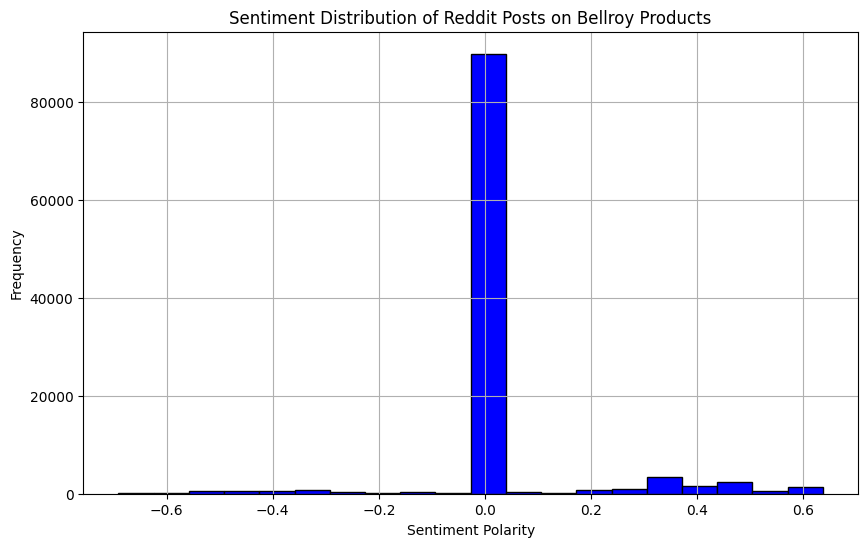

In [23]:
score_list= flatten(df['pool_score'].tolist())
plt.figure(figsize=(10, 6))
plt.hist(score_list, bins=20, color='blue', edgecolor='black')
plt.title('Sentiment Distribution of Reddit Posts on Bellroy Products')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This histogram shows the sentiment distribution of the reddit posts on bellroy's products. This shows that most of the reviews were slightly on the positive side (leaning towards neutrality) with a noticeable amount of positive sentiments and a relatively low negative sentiment.

In [24]:
df.label.value_counts()

 1    247
 0      8
-1      3
Name: label, dtype: int64

/var/folders/_6/k19_kjb552v4gfyyb6dyg1n40000gn/T/ipykernel_19932/4033784104.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])


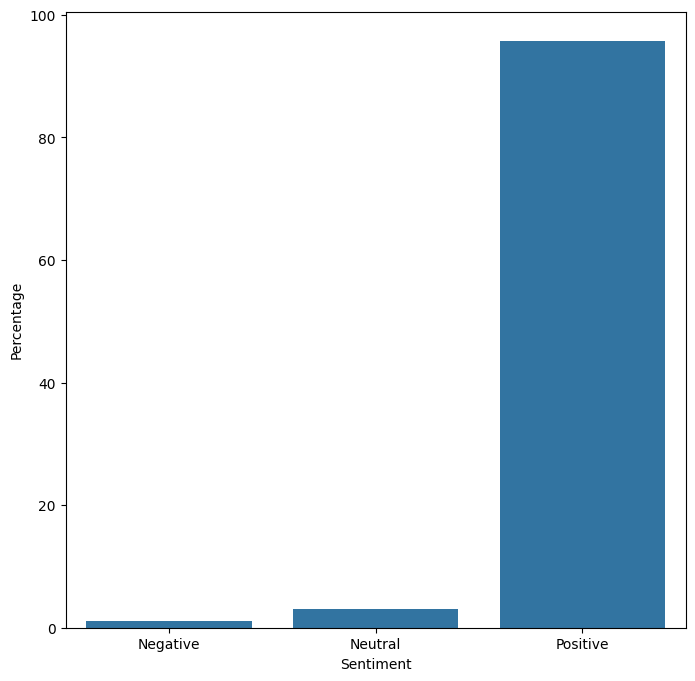

In [25]:
fig, ax = plt.subplots(figsize=(8,8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')

# plt.savefig('charts/bar.png')

plt.show()

This bar chart shows the distribution of sentiment across negative, neutral, and positive categories.  The sentiment distribution reveals that a significant majority of the reviews are positive, with a small percentage being neutral or negative. Specifically, approximately 95% of the reviews are positive, about 3% are neutral, and around 2% are negative.

In [26]:
df['all_words'] = df['title'] + df['selftext'] + df['comments_list']
df['all_words_flatten'] = df['all_words'].apply(flatten)

In [27]:
all_words = " ".join(x for x in df['all_words_flatten'].apply(lambda x: " ".join(x))).split(" ")
positive_words = " ".join(x for x in df[df['label'] == 1]['all_words_flatten'].apply(lambda x: " ".join(x))).split(" ")
negative_words = " ".join(x for x in df[df['label'] == -1]['all_words_flatten'].apply(lambda x: " ".join(x))).split(" ")

pos_freq = FreqDist(positive_words).most_common(5)
neg_freq = FreqDist(negative_words).most_common(5)
print('pos_freq\n', pos_freq)
print('neg_freq\n', neg_freq)

pos_freq
 [('like', 1365), ('case', 857), ('sling', 846), ('look', 773), ('would', 596)]
neg_freq
 [('warranty', 7), ('3', 6), ('price', 6), ('side', 5), ('year', 5)]


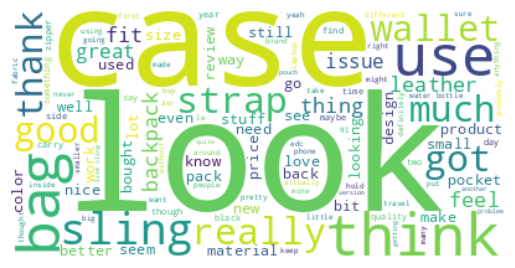

In [28]:
wordcloud_total = WordCloud(background_color="white").generate(" , ".join(all_words))
plt.imshow(wordcloud_total, interpolation='bilinear')
plt.axis('off')

# plt.savefig('charts/wordcloud_all.png')

plt.show()

This word cloud combines all reviews, highlighting the most frequently mentioned terms. The most prominent words include "price," "warranty," "year," "pocket," and "slide," indicating common themes in the discussions. These keywords suggest that users frequently discuss the cost, warranty period, and specific product features like pockets and slides.

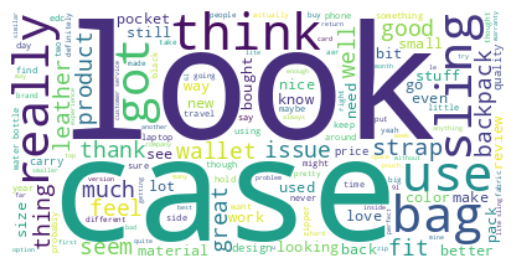

In [29]:
wordcloud_posit = WordCloud(background_color="white").generate(" , ".join(positive_words))
plt.imshow(wordcloud_posit, interpolation='bilinear')
plt.axis('off')

# plt.savefig('charts/word_cloud_posit.png')

plt.show()

This word cloud focuses on positive reviews. Positive reviews prominently feature words like "case," "look," "strap," "sling," and "use," indicating that users appreciate the design and functionality of Bellroy products. Terms such as "good," "perfect," and "love" are also frequent, highlighting overall customer satisfaction.

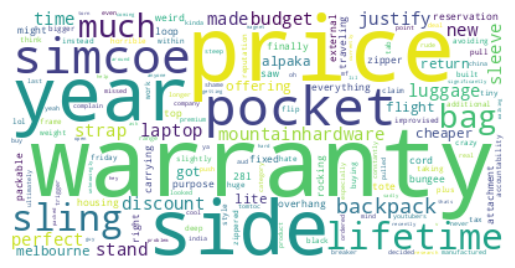

In [30]:
wordcloud_negat = WordCloud(background_color="white").generate(" , ".join(negative_words))
plt.imshow(wordcloud_negat, interpolation='bilinear')
plt.axis('off')

# plt.savefig('charts/word_cloud_negat.png')

plt.show()

This word cloud focuses on negative reviews. Negative reviews still feature many of the same terms as positive ones, such as "warranty," "price," and "pocket." However, the context of these terms might indicate issues related to these aspects, such as concerns over cost or product functionality.

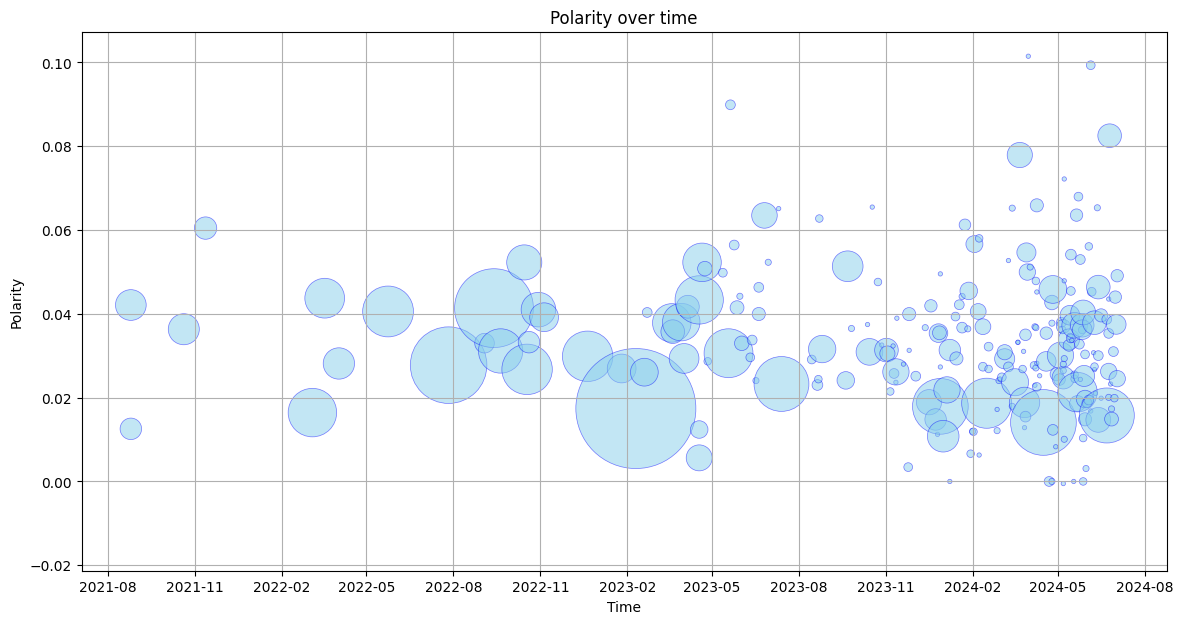

In [31]:
df = df.sort_values(['time_stamp'])

date = pd.to_datetime(df['time_stamp']).dt.date

mean = df['pool_score'].apply(lambda x: np.mean(x))

plt.figure(figsize=(14, 7))
plt.scatter(date, mean, s=df['upvotes']*10, alpha=0.5, color='skyblue', edgecolors='b', linewidth=0.5)
plt.title('Polarity over time')
plt.xlabel('Time')
# plt.xticks(rotation=45)
plt.ylabel('Polarity')
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# plt.savefig('charts/bubble.png')

plt.show()

This bubble chart (Melton, C.A. et al.(2021))shows the polarity of Reddit reviews over time, with the size of the bubbles representing the volume of reviews. The polarity values range mostly between 0.0 and 0.1, indicating that the overall sentiment of the reviews is slightly positive. Larger bubbles around specific time points suggest periods with higher review activity, which could correlate with product launches or promotions.

**visualisation of the evaluation results**

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)

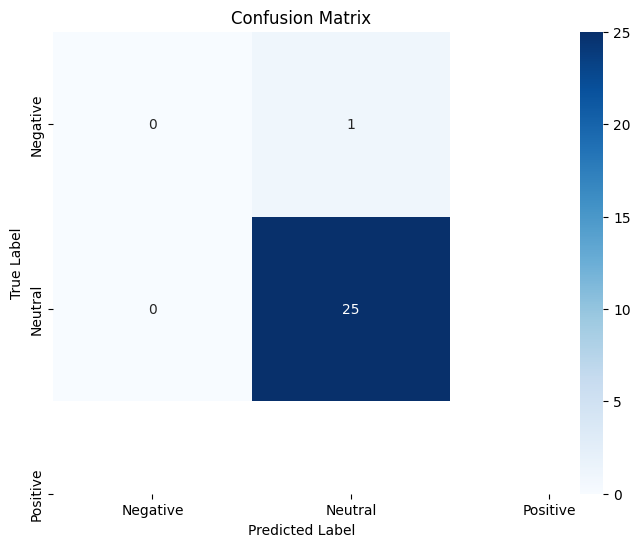

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

This confusion matrix shows that the current model with the available data is heavily skewed, given that the data is leaning towards neutral comments. This suggests that the model might not learn from distinguishing features for negative and positive sentiments effectively.

### DISCUSSIONS:
The sentiment analysis provides us with an insight to the customer sentiment and we are able to identify the key topics and trends that are discussed between them. 

While we do get an insight to the customers' sentiment we cannot assure the polarity of the scores as the VADER model does have a few disadvantages: 
- Misspellings and grammatical mistakes may cause the analysis to overlook important words or usage.
- Sarcasm and irony may be misinterpreted.
- Analysis is language-specific.
- Discriminating jargon, nomenclature, memes, or turns of phrase may not be recognized (www.codeproject.com. (n.d.)).

### RECOMMENDATIONS:
- Regularly monitor and scrape the reddit forum for real-time customer feedback. These reviews can also be obtained from different social media channels.
- For a better model; as seen from the confusion matrix; a better balanced dataset should be collected. This can be done with regularly collecting the data and labelling them accordingly. 
- Use the insights from the negative sentiments to improve the quality and enhance customer satisfaction. For example: 
    - As seen in the negative word cloud, customers are mainly concerned of the price and the warranty of the products. The company can leverage this information and can improve their pricing model and warranty clause.

### REFERENCES:
Bellroy (2023). We are all the things with you. [online] bellroy.com. Available at: https://bellroy.com/about-us.

Bisson, R. (2020). Is Reddit a reliable source for information? [online] line a geek. Available at: https://www.lineageek.com/is-reddit-a-reliable-source-for-information/ [Accessed 28 Jun. 2024].

praw.readthedocs.io. (n.d.). PRAW 7.7.1 documentation. [online] Available at: https://praw.readthedocs.io/en/stable/index.html [Accessed 28 Jun. 2024].

Melton, C.A., Olusanya, O.A., Ammar, N. and Shaban-Nejad, A. (2021). Public sentiment analysis and topic modeling regarding COVID-19 vaccines on the Reddit social media platform: A call to action for strengthening vaccine confidence. Journal of Infection and Public Health, 14(10). doi:https://doi.org/10.1016/j.jiph.2021.08.010.

vadersentiment.readthedocs.io. (n.d.). VADER-Sentiment-Analysis Introduction — VaderSentiment 3.3.1 documentation. [online] Available at: https://vadersentiment.readthedocs.io/en/latest/pages/introduction.html [Accessed 29 Jun. 2024].

www.nltk.org. (n.d.). NLTK :: nltk.sentiment.vader module. [online] Available at: https://www.nltk.org/api/nltk.sentiment.vader.html.

www.codeproject.com. (n.d.). Pros and Cons of NLTK Sentiment Analysis with VADER. [online] Available at: https://www.codeproject.com/Articles/5269447/Pros-and-Cons-of-NLTK-Sentiment-Analysis-with-VADE.